# 📊 F1 YouTube Descriptive Analytics - EDA & Visualizations

## Notebook 04: Exploratory Data Analysis & Visualization

This notebook computes and visualizes all requested analytics metrics:

### 1. Driver Engagement Analytics
- Driver Share of Voice (SoV)
- Driver Sentiment Score
- Headline Impact
- Rivalry Intensity

### 2. Audience Sentiment & Reaction
- Global Sentiment Distribution
- Top Fan Favorite Comments
- Controversy Index
- Polarity vs Performance Correlation

### 3. Video Performance Metrics
- Engagement Rate Rankings
- Video Reach Rankings
- Virality Potential

### 4. Content & Topic Analysis
- Dominant Keyword Cloud
- Team Mention Frequency
- Temporal Activity Heatmap

In [38]:
# Setup and imports (robust project-root detection)
import sys
from pathlib import Path

def _find_project_root() -> Path:
    cwd = Path.cwd().resolve()
    # If running from within Descriptive/, this will match
    for base in [cwd, *cwd.parents]:
        if (base / 'src' / 'config.py').exists():
            return base
        # If running from workspace root (contains Descriptive/ folder), this will match
        if (base / 'Descriptive' / 'src' / 'config.py').exists():
            return base / 'Descriptive'
    raise FileNotFoundError(
        "Could not locate the Descriptive project root containing src/config.py. "
        "Run this notebook from the project workspace, or open it from the Descriptive/notebooks folder."
    )

PROJECT_ROOT = _find_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Ensure we import the local `src` package (not an unrelated installed package named `src`)
for mod in list(sys.modules.keys()):
    if mod == 'src' or mod.startswith('src.'):
        del sys.modules[mod]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

from src import config
from src import utils
from src.analytics import F1DescriptiveAnalytics

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ Imports successful!")
print(f"📌 Using project root: {PROJECT_ROOT}")

✅ Imports successful!
📌 Using project root: C:\Users\ahmed\Downloads\dba-youtube-project\Descriptive


In [39]:
# Load data (robust to missing/empty raw & processed outputs)
from pathlib import Path

def _read_csv_if_nonempty(path: Path):
    path = Path(path)
    if (not path.exists()) or path.stat().st_size == 0:
        return None
    try:
        df = pd.read_csv(path)
    except pd.errors.EmptyDataError:
        return None
    except FileNotFoundError:
        return None
    if df.shape[1] == 0:
        return None
    return df

def _pick_first_available_csv(paths, label: str):
    for p in paths:
        df = _read_csv_if_nonempty(p)
        if df is not None:
            print(f"✅ Loaded {label} from: {Path(p).name}")
            return df
    return None

# Prefer engineered/processed datasets, then fall back to raw exports (if present)
videos = _pick_first_available_csv(
    [
        config.FEATURES_CSV,
        config.CLEAN_DATASET_CSV,
        config.VIDEOS_CSV,
    ],
    label="videos",
)

# If the full videos datasets are missing/empty, build a minimal videos table from the non-empty report CSVs
if videos is None:
    fallback_video_paths = [
        config.PROCESSED_DATA_DIR / 'top_reach.csv',
        config.PROCESSED_DATA_DIR / 'top_engagement.csv',
        config.PROCESSED_DATA_DIR / 'top_virality.csv',
        config.PROCESSED_DATA_DIR / 'controversial_videos.csv',
    ]
    fallback_frames = [df for df in (_read_csv_if_nonempty(p) for p in fallback_video_paths) if df is not None]
    if fallback_frames:
        videos = (
            pd.concat(fallback_frames, ignore_index=True)
            .drop_duplicates(subset=['video_id'])
            .reset_index(drop=True)
        )
        print(
            "⚠️ Full videos dataset is missing/empty; using a minimal videos table built from processed reports "
            f"({len(videos)} videos). For full analysis, run 01_extraction → 03_feature_eng."
        )
        # Coerce numerics if they arrived as strings
        for col in ['view_count', 'like_count', 'comment_count', 'engagement_rate', 'controversy_index']:
            if col in videos.columns:
                videos[col] = pd.to_numeric(videos[col], errors='coerce')
        if 'published_at' in videos.columns:
            videos['published_at'] = pd.to_datetime(videos['published_at'], errors='coerce', utc=True)
    else:
        raise FileNotFoundError(
            "Could not find any videos dataset to load.\n"
            f"Looked for: {config.FEATURES_CSV.name}, {config.CLEAN_DATASET_CSV.name}, {config.VIDEOS_CSV.name}.\n"
            "Also checked processed report CSVs (top_reach/top_engagement/top_virality/controversial_videos) but they were missing/empty.\n\n"
            "Fix: run notebook 01_extraction.ipynb (and then 02_cleaning/03_feature_eng), or run Descriptive/run_analytics.py."
        )

comments_features_path = config.PROCESSED_DATA_DIR / 'comments_with_features.csv'
comments_sentiment_path = config.PROCESSED_DATA_DIR / 'comments_with_sentiment.csv'
comments = _pick_first_available_csv(
    [
        comments_features_path,
        comments_sentiment_path,
        config.COMMENTS_CSV,
    ],
    label="comments",
)
if comments is None:
    raise FileNotFoundError(
        "Could not find any comments dataset to load.\n"
        f"Looked for: {comments_features_path.name}, {comments_sentiment_path.name}, {config.COMMENTS_CSV.name}.\n\n"
        "Fix: run notebook 01_extraction.ipynb (and then 02_cleaning/03_feature_eng), or run Descriptive/run_analytics.py to generate the CSVs."
    )

# Convert string columns back to lists for analysis (only if those columns exist)
if 'drivers_mentioned_str' in comments.columns and 'drivers_mentioned' not in comments.columns:
    comments['drivers_mentioned'] = comments['drivers_mentioned_str'].apply(utils.string_to_list)
if 'teams_mentioned_str' in comments.columns and 'teams_mentioned' not in comments.columns:
    comments['teams_mentioned'] = comments['teams_mentioned_str'].apply(utils.string_to_list)
if 'rivalries_detected_str' in comments.columns and 'rivalries_detected' not in comments.columns:
    comments['rivalries_detected'] = comments['rivalries_detected_str'].apply(
        lambda x: [tuple(r.split('vs')) for r in x.split('|') if r] if pd.notna(x) and x else []
    )

if 'drivers_in_title_str' in videos.columns and 'drivers_in_title' not in videos.columns:
    videos['drivers_in_title'] = videos['drivers_in_title_str'].apply(utils.string_to_list)

# Ensure a month column exists for temporal charts (if any datetime column exists)
if 'month' not in comments.columns:
    candidate_date_cols = [
        'comment_published_at',
        'published_at',
        'updated_at',
        'comment_time',
        'created_at',
    ]
    date_col = next((c for c in candidate_date_cols if c in comments.columns), None)
    if date_col is not None:
        dt = pd.to_datetime(comments[date_col], errors='coerce', utc=True)
        comments['month'] = dt.dt.month

print(f"📊 Loaded {len(videos)} videos and {len(comments)} comments")

⚠️ Full videos dataset is missing/empty; using a minimal videos table built from processed reports (57 videos). For full analysis, run 01_extraction → 03_feature_eng.
✅ Loaded comments from: comments_with_sentiment.csv
📊 Loaded 57 videos and 7361 comments


In [55]:
# Initialize analytics engine
analytics = F1DescriptiveAnalytics(videos, comments)

---
# 🏎️ 1. DRIVER ENGAGEMENT ANALYTICS

## 1.1 Driver Share of Voice (SoV)
*Which drivers are most discussed in comments?*

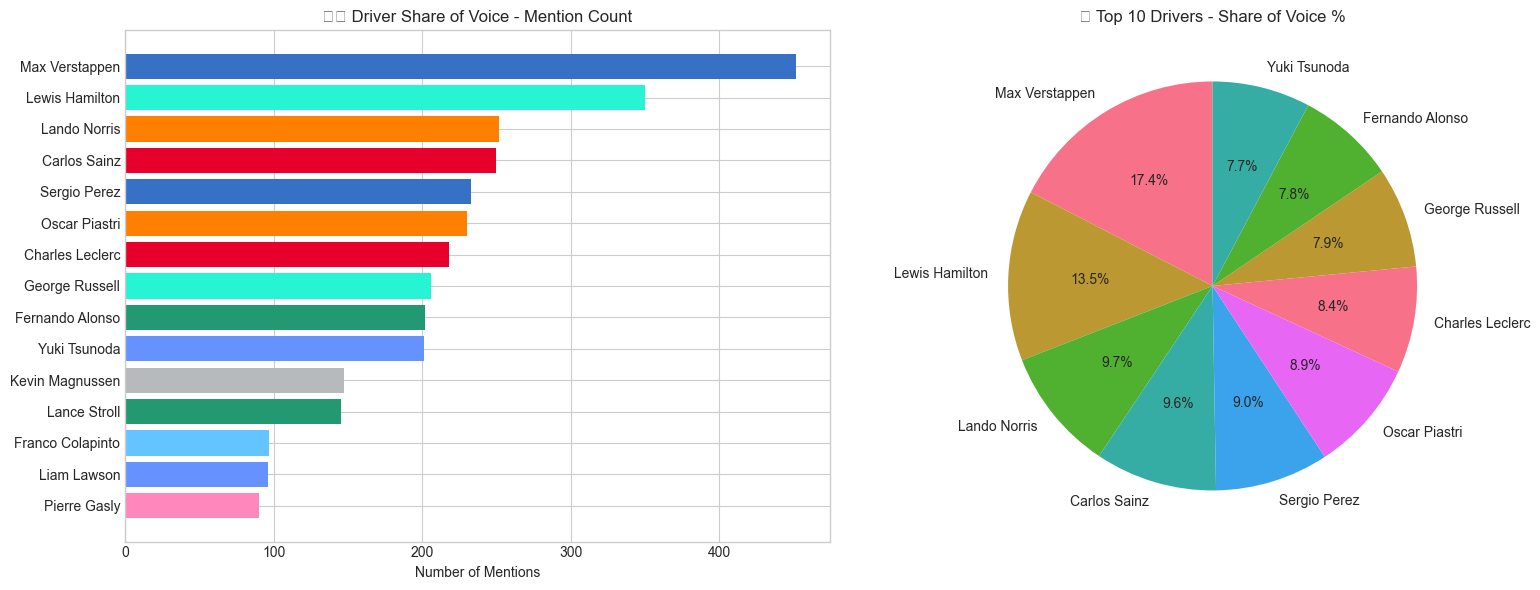

,driver,mention_count,share_of_voice_pct,share_of_driver_comments_pct
0,verstappen,452,6.140470,15.618521
1,hamilton,350,4.754789,12.093988
2,norris,252,3.423448,8.707671
3,sainz,250,3.396278,8.638563
4,perez,233,3.165331,8.051140
5,piastri,230,3.124575,7.947478
6,leclerc,218,2.961554,7.532827
7,russell,206,2.798533,7.118176
8,alonso,202,2.744192,6.979959
9,tsunoda,201,2.730607,6.945404


In [41]:
# Calculate Driver Share of Voice
driver_sov = analytics.driver_share_of_voice()

# Visualize top 15 drivers by mention count
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart - Mention Count
top_drivers = driver_sov.head(15)
colors = [config.TEAM_COLORS.get(
    config.DRIVERS.get(d, {}).get('team', '').lower().replace(' ', '_'), '#808080'
) for d in top_drivers['driver']]

axes[0].barh(range(len(top_drivers)), top_drivers['mention_count'], color=colors)
axes[0].set_yticks(range(len(top_drivers)))
axes[0].set_yticklabels([config.DRIVERS.get(d, {}).get('full_name', d) for d in top_drivers['driver']])
axes[0].invert_yaxis()
axes[0].set_xlabel('Number of Mentions')
axes[0].set_title('🏎️ Driver Share of Voice - Mention Count')

# Pie chart - Share of Voice
top_10 = driver_sov.head(10)
axes[1].pie(top_10['share_of_voice_pct'], labels=[config.DRIVERS.get(d, {}).get('full_name', d)[:15] for d in top_10['driver']],
            autopct='%1.1f%%', startangle=90)
axes[1].set_title('📊 Top 10 Drivers - Share of Voice %')

plt.tight_layout()
plt.show()

driver_sov.head(10)

## 1.2 Driver Sentiment Score
*Are comments about certain drivers more positive or negative?*

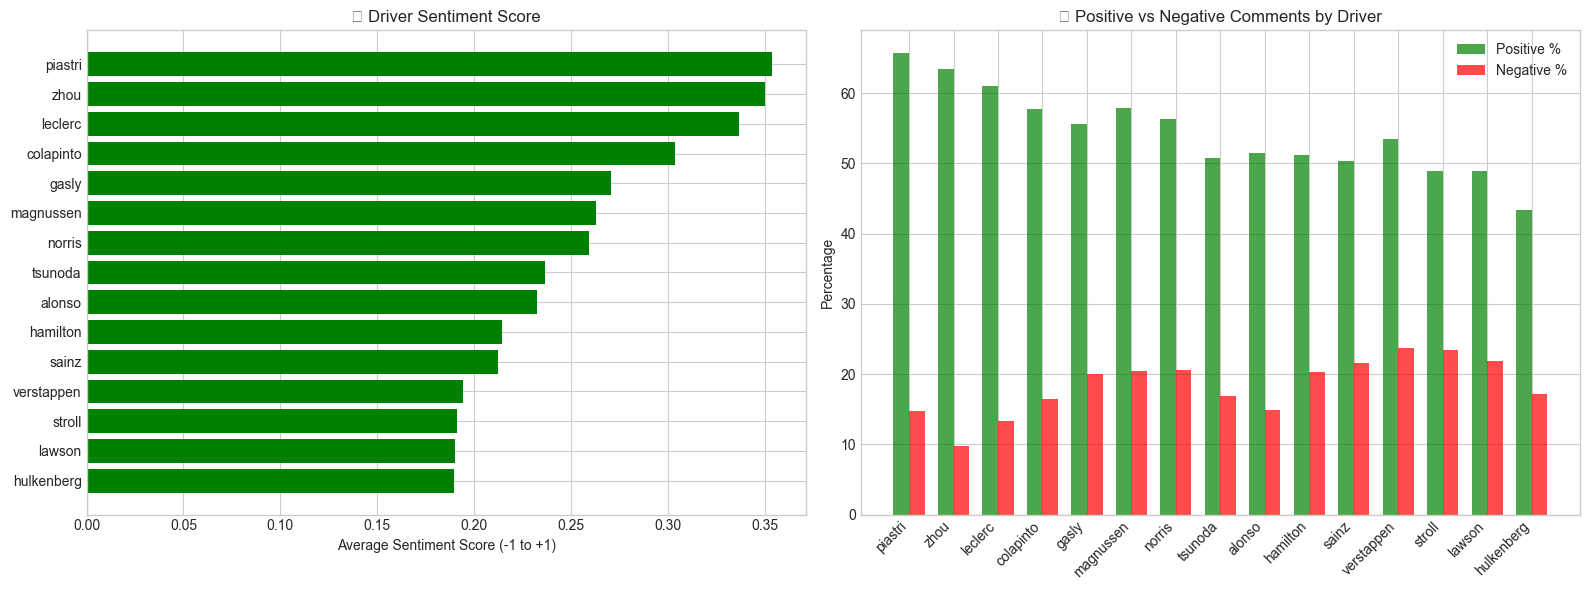

,driver,avg_sentiment,positive_pct,negative_pct,comment_count
2,piastri,0.353612,65.652174,14.782609,230
17,zhou,0.350145,63.414634,9.756098,82
6,leclerc,0.336911,61.009174,13.302752,218
16,colapinto,0.303980,57.731959,16.494845,97
14,gasly,0.270808,55.555556,20.000000,90
18,magnussen,0.262862,57.823129,20.408163,147
0,norris,0.259259,56.349206,20.634921,252
10,tsunoda,0.236693,50.746269,16.915423,201
3,alonso,0.232546,51.485149,14.851485,202
7,hamilton,0.214451,51.142857,20.285714,350


In [42]:
# Calculate Driver Sentiment Scores
driver_sentiment = analytics.driver_sentiment_scores()

# Filter drivers with enough data
driver_sentiment_filtered = driver_sentiment[driver_sentiment['comment_count'] >= 10].head(15)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Average sentiment bar chart
colors = ['green' if x > 0 else 'red' for x in driver_sentiment_filtered['avg_sentiment']]
axes[0].barh(range(len(driver_sentiment_filtered)), driver_sentiment_filtered['avg_sentiment'], color=colors)
axes[0].set_yticks(range(len(driver_sentiment_filtered)))
axes[0].set_yticklabels(driver_sentiment_filtered['driver'])
axes[0].invert_yaxis()
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_xlabel('Average Sentiment Score (-1 to +1)')
axes[0].set_title('🎭 Driver Sentiment Score')

# Positive vs Negative percentage
x = range(len(driver_sentiment_filtered))
width = 0.35
axes[1].bar([i - width/2 for i in x], driver_sentiment_filtered['positive_pct'], width, label='Positive %', color='green', alpha=0.7)
axes[1].bar([i + width/2 for i in x], driver_sentiment_filtered['negative_pct'], width, label='Negative %', color='red', alpha=0.7)
axes[1].set_xticks(x)
axes[1].set_xticklabels(driver_sentiment_filtered['driver'], rotation=45, ha='right')
axes[1].set_ylabel('Percentage')
axes[1].set_title('📊 Positive vs Negative Comments by Driver')
axes[1].legend()

plt.tight_layout()
plt.show()

driver_sentiment_filtered[['driver', 'avg_sentiment', 'positive_pct', 'negative_pct', 'comment_count']].head(10)

## 1.3 Headline Impact
*Which drivers in video titles generate the most views?*

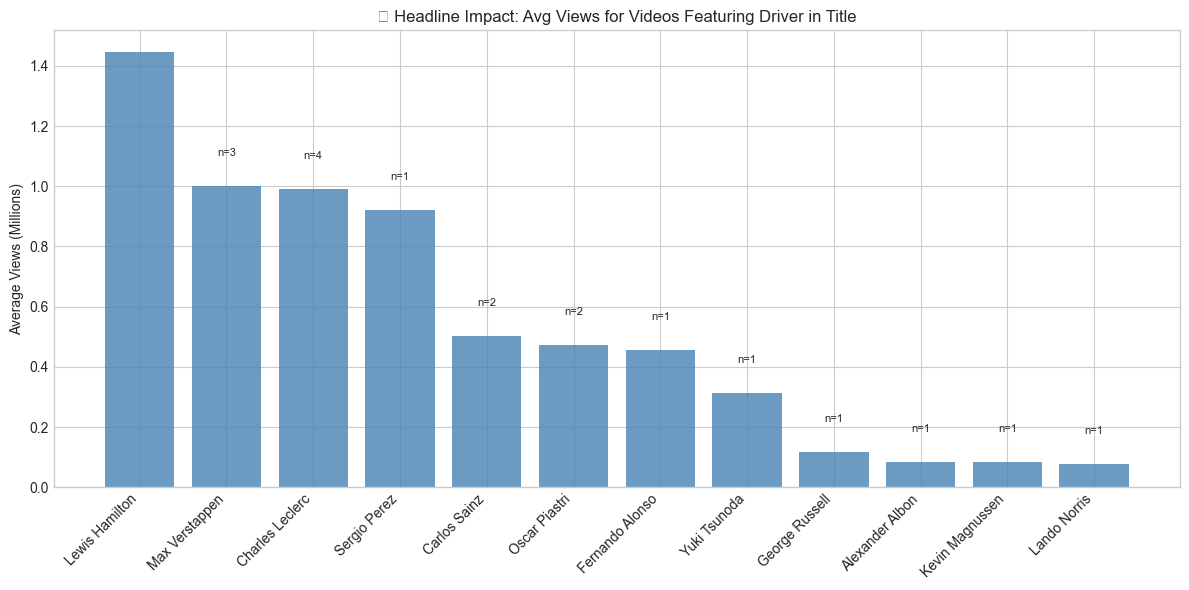

,driver,video_count,avg_views,avg_likes,avg_comments,avg_engagement_rate,total_views
1,hamilton,6,1.445760e+06,34944.000000,1510.666667,2.544629,8674557
2,verstappen,3,1.001903e+06,45430.666667,374.666667,5.189276,3005710
0,leclerc,4,9.918300e+05,53814.250000,243.750000,6.693540,3967320
7,perez,1,9.223990e+05,16985.000000,2754.000000,2.139963,922399
5,sainz,2,5.024770e+05,11365.000000,1401.500000,4.579157,1004954
8,piastri,2,4.738965e+05,13214.000000,1072.000000,3.813117,947793
9,alonso,1,4.555480e+05,9712.000000,567.000000,2.256403,455548
4,tsunoda,1,3.137060e+05,23411.000000,227.000000,7.535081,313706
6,russell,1,1.177010e+05,7172.000000,88.000000,6.168172,117701
10,albon,1,8.363500e+04,3040.000000,161.000000,3.827345,83635


In [43]:
# Calculate Headline Impact
headline_impact = analytics.headline_impact()

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

if not headline_impact.empty:
    top_headline = headline_impact.head(12)
    
    x = range(len(top_headline))
    ax.bar(x, top_headline['avg_views'] / 1e6, color='steelblue', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels([config.DRIVERS.get(d, {}).get('full_name', d) for d in top_headline['driver']], rotation=45, ha='right')
    ax.set_ylabel('Average Views (Millions)')
    ax.set_title('📺 Headline Impact: Avg Views for Videos Featuring Driver in Title')
    
    # Add video count annotations
    for i, row in enumerate(top_headline.itertuples()):
        ax.annotate(f'n={row.video_count}', (i, row.avg_views/1e6 + 0.1), ha='center', fontsize=8)
else:
    ax.text(0.5, 0.5, 'No driver headlines found', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

headline_impact.head(10)

## 1.4 Rivalry Intensity
*Which rivalry pairs generate the most discussion?*

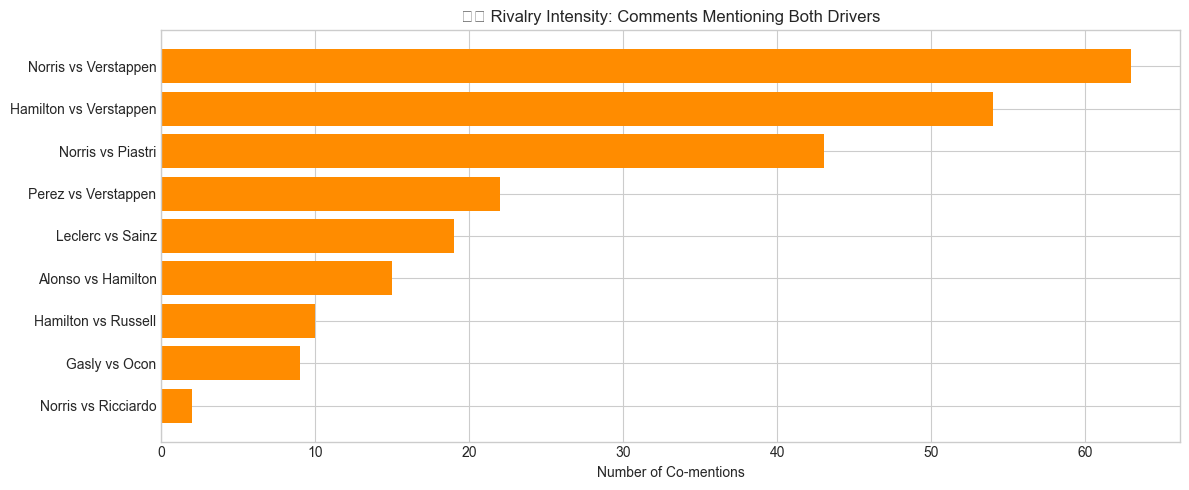

,driver_1,driver_2,rivalry_pair,comment_count,intensity_pct
0,norris,verstappen,norris vs verstappen,63,0.855862
1,hamilton,verstappen,hamilton vs verstappen,54,0.733596
2,norris,piastri,norris vs piastri,43,0.584160
3,perez,verstappen,perez vs verstappen,22,0.298872
4,leclerc,sainz,leclerc vs sainz,19,0.258117
5,alonso,hamilton,alonso vs hamilton,15,0.203777
6,hamilton,russell,hamilton vs russell,10,0.135851
7,gasly,ocon,gasly vs ocon,9,0.122266
8,norris,ricciardo,norris vs ricciardo,2,0.027170


In [44]:
# Calculate Rivalry Intensity
rivalry = analytics.rivalry_intensity()

fig, ax = plt.subplots(figsize=(12, 5))

if not rivalry.empty and rivalry['comment_count'].sum() > 0:
    rivalry_sorted = rivalry.sort_values('comment_count', ascending=True)
    
    # Create rivalry labels
    labels = [f"{config.DRIVERS.get(row['driver_1'], {}).get('full_name', row['driver_1']).split()[1]} vs {config.DRIVERS.get(row['driver_2'], {}).get('full_name', row['driver_2']).split()[-1]}" 
              for _, row in rivalry_sorted.iterrows()]
    
    ax.barh(range(len(rivalry_sorted)), rivalry_sorted['comment_count'], color='darkorange')
    ax.set_yticks(range(len(rivalry_sorted)))
    ax.set_yticklabels(labels)
    ax.set_xlabel('Number of Co-mentions')
    ax.set_title('⚔️ Rivalry Intensity: Comments Mentioning Both Drivers')
else:
    ax.text(0.5, 0.5, 'No rivalry co-mentions detected', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

rivalry

---
# 🎭 2. AUDIENCE SENTIMENT & REACTION

## 2.1 Global Sentiment Distribution
*What's the overall mood of F1 YouTube comments?*

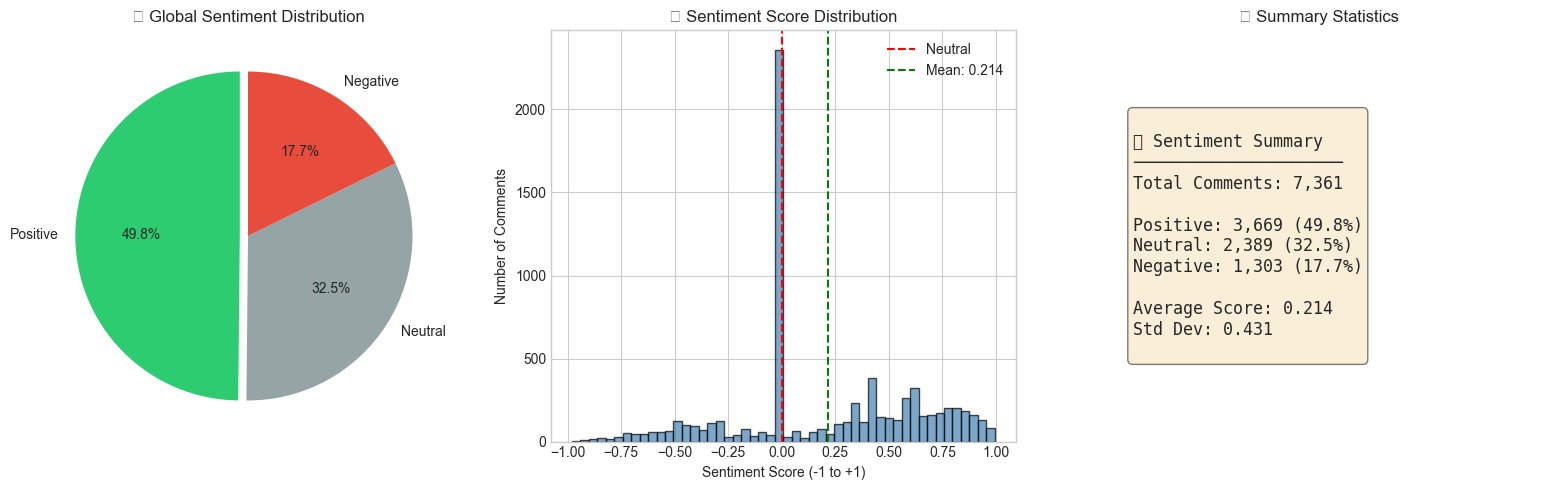

In [45]:
# Global Sentiment Distribution
sentiment_dist = analytics.global_sentiment_distribution()

# Ensure sentiment columns exist on the notebook-level `comments` df used for plotting
if 'sentiment_compound' not in comments.columns or 'sentiment_label' not in comments.columns:
    # `analytics` computes sentiment on its internal copy; reuse those results here
    comments = comments.copy()
    if 'sentiment_compound' in analytics.comments.columns:
        comments['sentiment_compound'] = analytics.comments['sentiment_compound'].values
    if 'sentiment_label' in analytics.comments.columns:
        comments['sentiment_label'] = analytics.comments['sentiment_label'].values

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Pie chart
labels = ['Positive', 'Neutral', 'Negative']
sizes = [sentiment_dist['positive_pct'], sentiment_dist['neutral_pct'], sentiment_dist['negative_pct']]
colors = ['#2ecc71', '#95a5a6', '#e74c3c']
explode = (0.05, 0, 0)

axes[0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0].set_title('🎭 Global Sentiment Distribution')

# Histogram of sentiment scores
axes[1].hist(comments['sentiment_compound'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', label='Neutral')
axes[1].axvline(x=comments['sentiment_compound'].mean(), color='green', linestyle='--', label=f'Mean: {comments["sentiment_compound"].mean():.3f}')
axes[1].set_xlabel('Sentiment Score (-1 to +1)')
axes[1].set_ylabel('Number of Comments')
axes[1].set_title('📊 Sentiment Score Distribution')
axes[1].legend()

# Summary stats
stats_text = f"""
📊 Sentiment Summary
─────────────────────
Total Comments: {sentiment_dist['total_comments']:,}

Positive: {sentiment_dist['positive_count']:,} ({sentiment_dist['positive_pct']:.1f}%)
Neutral: {sentiment_dist['neutral_count']:,} ({sentiment_dist['neutral_pct']:.1f}%)
Negative: {sentiment_dist['negative_count']:,} ({sentiment_dist['negative_pct']:.1f}%)

Average Score: {sentiment_dist['avg_sentiment']:.3f}
Std Dev: {sentiment_dist['std_sentiment']:.3f}
"""
axes[2].text(0.1, 0.5, stats_text, transform=axes[2].transAxes, fontsize=12, 
             verticalalignment='center', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[2].axis('off')
axes[2].set_title('📋 Summary Statistics')

plt.tight_layout()
plt.show()

## 2.2 Top Fan Favorite Comments
*Comments with the highest like counts (community consensus)*

In [46]:
# Top Fan Favorite Comments
top_comments = analytics.top_fan_favorite_comments(10)

print("🏆 TOP 10 FAN FAVORITE COMMENTS")
print("=" * 80)

for i, row in top_comments.iterrows():
    print(f"\n#{top_comments.index.get_loc(i)+1} | 👍 {row['like_count']:,} likes")
    print(f"Video: {row.get('video_title', 'N/A')[:60]}...")
    print(f"Comment: {row['text_original'][:200]}...")
    print("-" * 80)

🏆 TOP 10 FAN FAVORITE COMMENTS

#1 | 👍 27,850 likes
Video: The F1 Grid Does Secret Santa 2024!...
Comment: I love how like 25% of this video is just franco playing with his gift...
--------------------------------------------------------------------------------

#2 | 👍 27,674 likes
Video: The F1 Grid Does Secret Santa 2024!...
Comment: not franco throwing out the ferrari colors and immediately making carlos a new williams car 😭
he's such a gem...
--------------------------------------------------------------------------------

#3 | 👍 24,664 likes
Video: Race Highlights | 2024 Qatar Grand Prix...
Comment: Just a friendly reminder that in the last 4 races Zhou has scored more points than Perez...
--------------------------------------------------------------------------------

#4 | 👍 23,194 likes
Video: The F1 Grid Does Secret Santa 2024!...
Comment: “Who would disrespect you like that?” 
Lando, without a shred of hesitation: “George.” 😂...
-----------------------------------------------

## 2.3 Controversy Index
*Videos with high comment-to-like ratios (heated debates)*

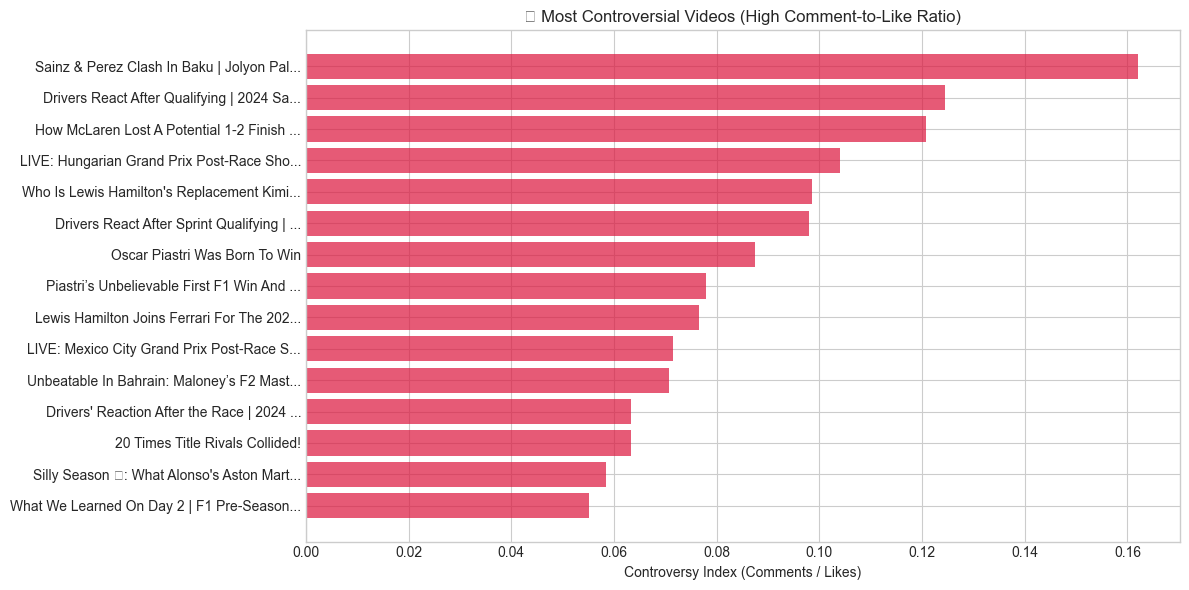

,title,view_count,comment_count,like_count,controversy_index
39,Sainz & Perez Clash In Baku | Jolyon Palmer's ...,922399,2754,16985,0.162143
42,Drivers React After Qualifying | 2024 Sao Paul...,366768,912,7331,0.124403
46,How McLaren Lost A Potential 1-2 Finish At Sil...,221705,650,5385,0.120706
44,LIVE: Hungarian Grand Prix Post-Race Show,544991,829,7969,0.104028
47,Who Is Lewis Hamilton's Replacement Kimi Anton...,128388,311,3155,0.098574
43,Drivers React After Sprint Qualifying | 2024 A...,382341,878,8954,0.098057
48,Oscar Piastri Was Born To Win,189643,784,8972,0.087383
40,Piastri’s Unbelievable First F1 Win And The Be...,758150,1360,17456,0.077910
10,Lewis Hamilton Joins Ferrari For The 2025 F1 S...,2223754,5553,72474,0.076621
49,LIVE: Mexico City Grand Prix Post-Race Show,342495,407,5691,0.071516


In [47]:
# Controversy Index Ranking
controversial = analytics.controversy_index_ranking(15)

fig, ax = plt.subplots(figsize=(12, 6))

if not controversial.empty:
    ax.barh(range(len(controversial)), controversial['controversy_index'], color='crimson', alpha=0.7)
    ax.set_yticks(range(len(controversial)))
    ax.set_yticklabels([t[:40] + '...' if len(t) > 40 else t for t in controversial['title']])
    ax.invert_yaxis()
    ax.set_xlabel('Controversy Index (Comments / Likes)')
    ax.set_title('🔥 Most Controversial Videos (High Comment-to-Like Ratio)')
else:
    ax.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

controversial[['title', 'view_count', 'comment_count', 'like_count', 'controversy_index']].head(10)

## 2.4 Polarity vs Performance Correlation
*Do positive videos get more views?*

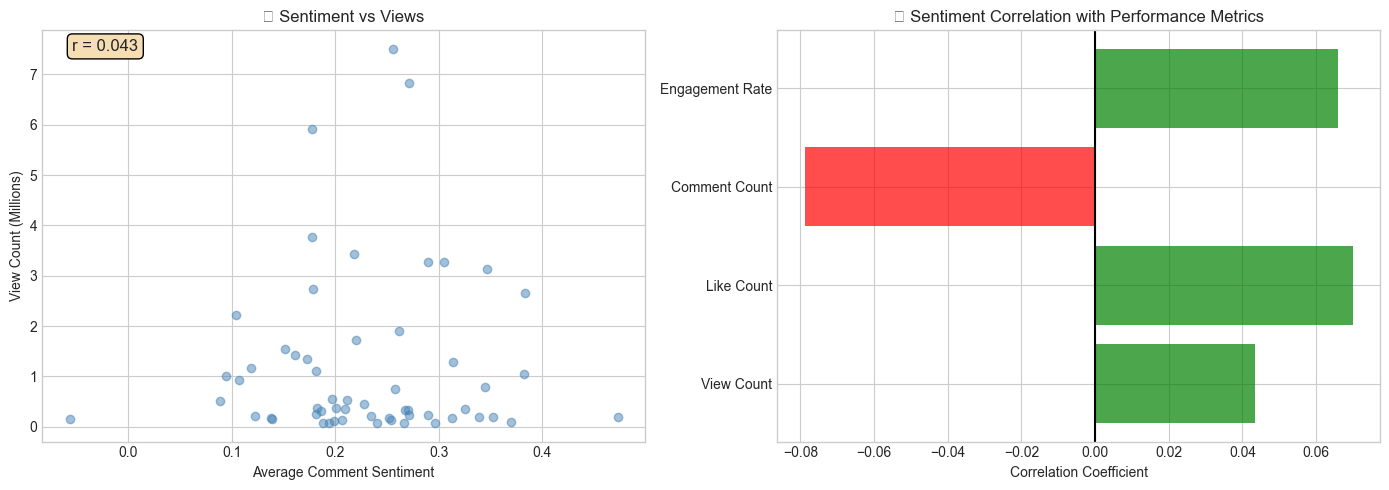

📊 Correlation Results:
  sentiment_vs_view_count: 0.0434
  sentiment_vs_like_count: 0.0699
  sentiment_vs_comment_count: -0.0789
  sentiment_vs_engagement_rate: 0.0659


In [48]:
# Calculate correlations
correlations = analytics.polarity_vs_performance_correlation()

# Calculate average sentiment per video for scatter plot
video_sentiment = comments.groupby('video_id')['sentiment_compound'].mean().reset_index()
video_sentiment.columns = ['video_id', 'avg_sentiment']
merged = videos.merge(video_sentiment, on='video_id', how='inner')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Sentiment vs Views
axes[0].scatter(merged['avg_sentiment'], merged['view_count'] / 1e6, alpha=0.5, c='steelblue')
axes[0].set_xlabel('Average Comment Sentiment')
axes[0].set_ylabel('View Count (Millions)')
axes[0].set_title('📈 Sentiment vs Views')
if 'sentiment_vs_view_count' in correlations:
    axes[0].annotate(f'r = {correlations["sentiment_vs_view_count"]:.3f}', xy=(0.05, 0.95), 
                     xycoords='axes fraction', fontsize=12, 
                     bbox=dict(boxstyle='round', facecolor='wheat'))

# Correlation heatmap
corr_df = pd.DataFrame({
    'Metric': ['View Count', 'Like Count', 'Comment Count', 'Engagement Rate'],
    'Correlation': [
        correlations.get('sentiment_vs_view_count', 0),
        correlations.get('sentiment_vs_like_count', 0),
        correlations.get('sentiment_vs_comment_count', 0),
        correlations.get('sentiment_vs_engagement_rate', 0)
    ]
})
colors = ['green' if x > 0 else 'red' for x in corr_df['Correlation']]
axes[1].barh(corr_df['Metric'], corr_df['Correlation'], color=colors, alpha=0.7)
axes[1].axvline(x=0, color='black', linestyle='-')
axes[1].set_xlabel('Correlation Coefficient')
axes[1].set_title('🔗 Sentiment Correlation with Performance Metrics')

plt.tight_layout()
plt.show()

print("📊 Correlation Results:")
for key, value in correlations.items():
    print(f"  {key}: {value:.4f}")

---
# 📺 3. VIDEO PERFORMANCE METRICS

## 3.1 Engagement Rate Ranking

In [49]:
# Video Performance Summary
performance = analytics.video_performance_summary()

print("📊 VIDEO PERFORMANCE SUMMARY")
print("=" * 50)
print(f"Total Videos: {performance['total_videos']}")
print(f"Total Views: {performance['total_views']:,}")
print(f"Total Likes: {performance['total_likes']:,}")
print(f"Total Comments: {performance['total_comments']:,}")
print(f"\nAverages per Video:")
print(f"  Views: {performance['avg_views']:,.0f}")
print(f"  Likes: {performance['avg_likes']:,.0f}")
print(f"  Comments: {performance['avg_comments']:,.0f}")
print(f"  Engagement Rate: {performance['avg_engagement_rate']:.4f}%")

📊 VIDEO PERFORMANCE SUMMARY
Total Videos: 57
Total Views: 68,744,501
Total Likes: 1,830,705
Total Comments: 53,498

Averages per Video:
  Views: 1,206,044
  Likes: 32,118
  Comments: 939
  Engagement Rate: 4.1085%


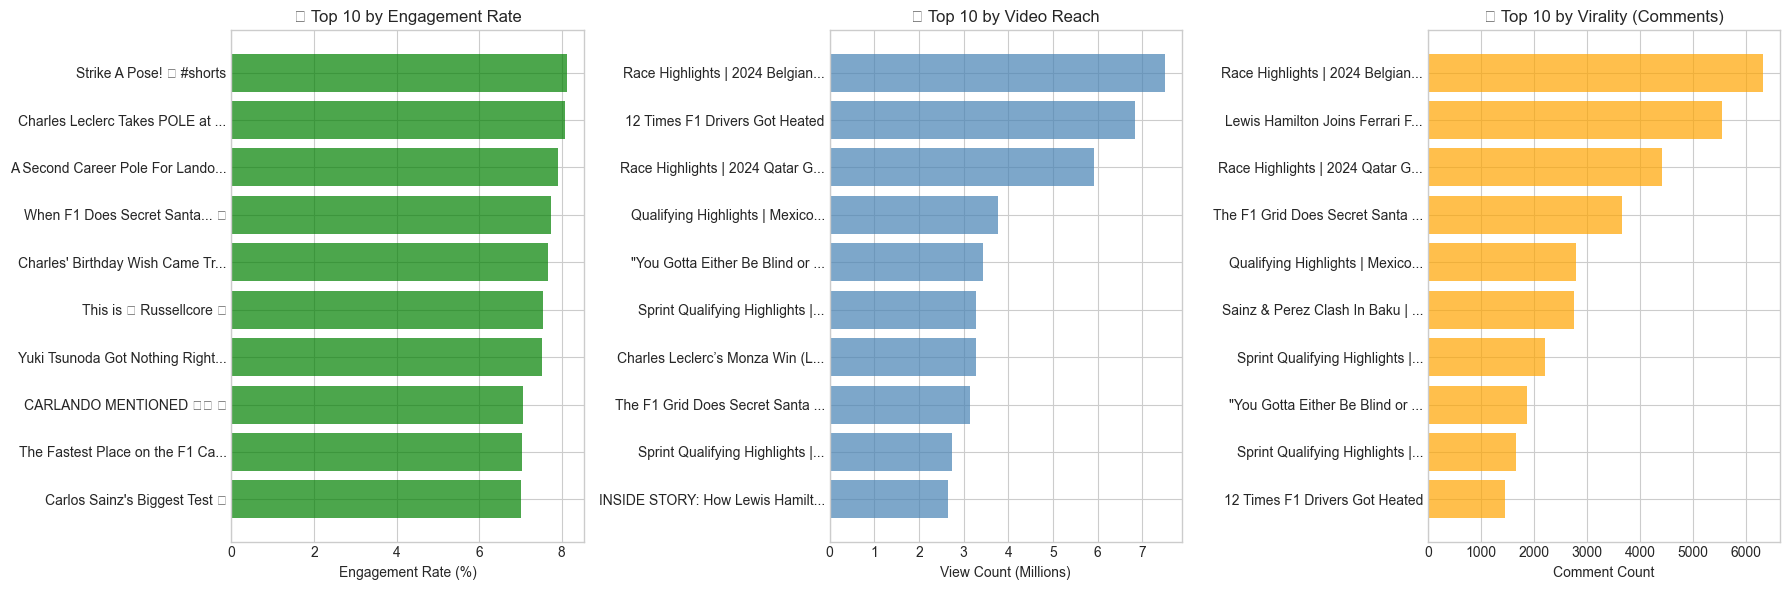

In [50]:
# Top videos by different metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Top by Engagement Rate
top_engagement = analytics.engagement_rate_ranking(10)
axes[0].barh(range(len(top_engagement)), top_engagement['engagement_rate'], color='green', alpha=0.7)
axes[0].set_yticks(range(len(top_engagement)))
axes[0].set_yticklabels([t[:30]+'...' if len(t)>30 else t for t in top_engagement['title']])
axes[0].invert_yaxis()
axes[0].set_xlabel('Engagement Rate (%)')
axes[0].set_title('🎯 Top 10 by Engagement Rate')

# Top by Views (Reach)
top_reach = analytics.video_reach_ranking(10)
axes[1].barh(range(len(top_reach)), top_reach['view_count'] / 1e6, color='steelblue', alpha=0.7)
axes[1].set_yticks(range(len(top_reach)))
axes[1].set_yticklabels([t[:30]+'...' if len(t)>30 else t for t in top_reach['title']])
axes[1].invert_yaxis()
axes[1].set_xlabel('View Count (Millions)')
axes[1].set_title('👀 Top 10 by Video Reach')

# Top by Comments (Virality)
top_viral = analytics.virality_potential_ranking(10)
axes[2].barh(range(len(top_viral)), top_viral['comment_count'], color='orange', alpha=0.7)
axes[2].set_yticks(range(len(top_viral)))
axes[2].set_yticklabels([t[:30]+'...' if len(t)>30 else t for t in top_viral['title']])
axes[2].invert_yaxis()
axes[2].set_xlabel('Comment Count')
axes[2].set_title('🚀 Top 10 by Virality (Comments)')

plt.tight_layout()
plt.show()

---
# 📝 4. CONTENT & TOPIC ANALYSIS

## 4.1 Dominant Keyword Cloud
*What are fans talking about?*

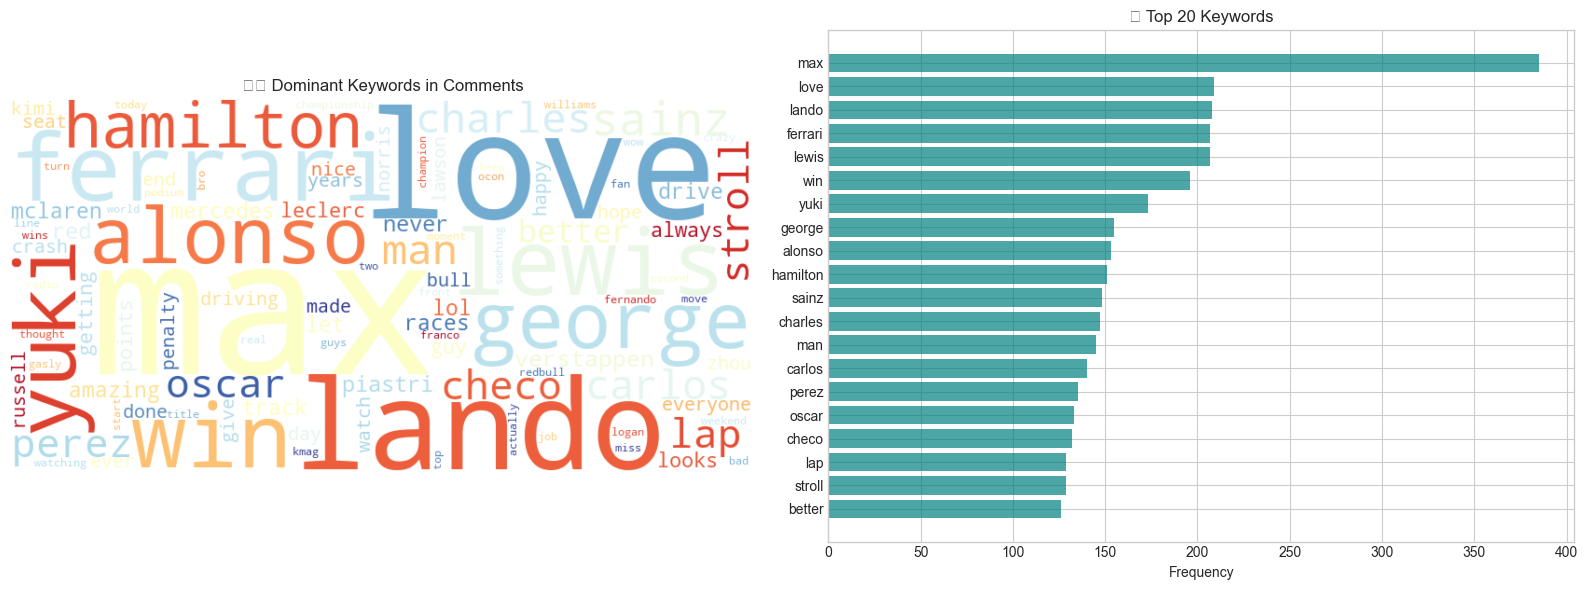

In [51]:
# Extract keywords and create word cloud
keywords = analytics.dominant_keywords('comments', 100)

# Create word cloud
word_freq = dict(keywords)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Word Cloud
if word_freq:
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='RdYlBu',
        max_words=100
    ).generate_from_frequencies(word_freq)
    
    axes[0].imshow(wordcloud, interpolation='bilinear')
    axes[0].axis('off')
    axes[0].set_title('☁️ Dominant Keywords in Comments')
else:
    axes[0].text(0.5, 0.5, 'No keywords found', ha='center', va='center', transform=axes[0].transAxes)

# Top 20 keywords bar chart
top_keywords = keywords[:20]
if top_keywords:
    words, counts = zip(*top_keywords)
    axes[1].barh(range(len(words)), counts, color='teal', alpha=0.7)
    axes[1].set_yticks(range(len(words)))
    axes[1].set_yticklabels(words)
    axes[1].invert_yaxis()
    axes[1].set_xlabel('Frequency')
    axes[1].set_title('📊 Top 20 Keywords')

plt.tight_layout()
plt.show()

## 4.2 Team Mention Frequency
*Which teams dominate the conversation?*

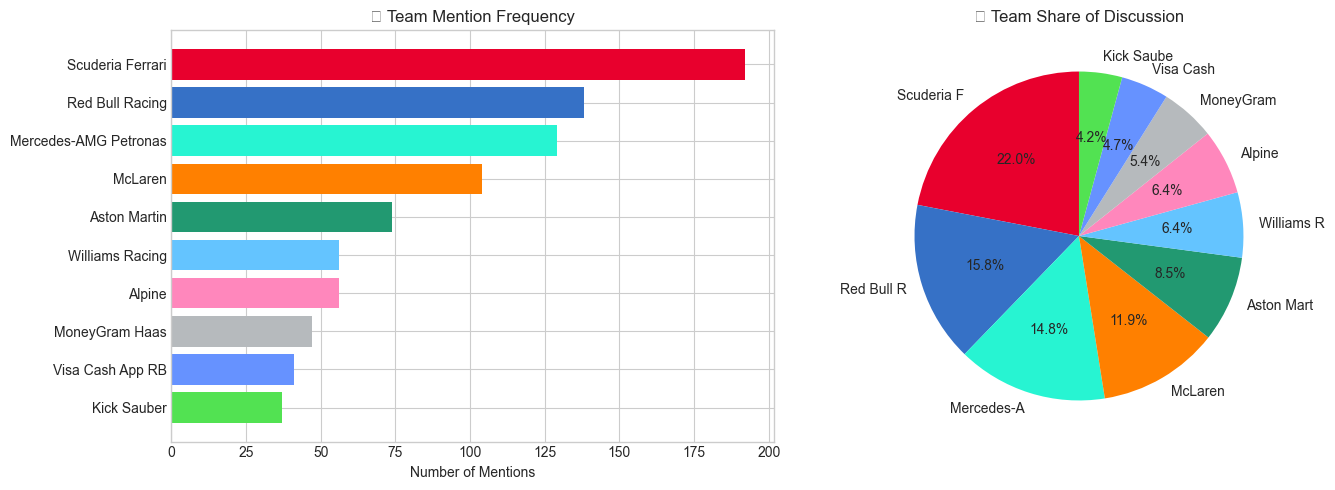

,team,mention_count,mention_pct,color
0,ferrari,192,2.608341,#E8002D
1,red_bull,138,1.874745,#3671C6
2,mercedes,129,1.752479,#27F4D2
3,mclaren,104,1.412852,#FF8000
4,aston_martin,74,1.005298,#229971
5,williams,56,0.760766,#64C4FF
6,alpine,56,0.760766,#FF87BC
7,haas,47,0.638500,#B6BABD
8,rb,41,0.556990,#6692FF
9,sauber,37,0.502649,#52E252


In [52]:
# Team Mention Frequency
team_mentions = analytics.team_mention_frequency()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if not team_mentions.empty:
    # Bar chart with team colors
    colors = [config.TEAM_COLORS.get(t, '#808080') for t in team_mentions['team']]
    team_names = [config.TEAMS.get(t, {}).get('full_name', t) for t in team_mentions['team']]
    
    axes[0].barh(range(len(team_mentions)), team_mentions['mention_count'], color=colors)
    axes[0].set_yticks(range(len(team_mentions)))
    axes[0].set_yticklabels(team_names)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Number of Mentions')
    axes[0].set_title('🏁 Team Mention Frequency')
    
    # Pie chart
    axes[1].pie(team_mentions['mention_count'], labels=[t[:10] for t in team_names], 
                colors=colors, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('📊 Team Share of Discussion')
else:
    axes[0].text(0.5, 0.5, 'No team mentions found', ha='center', va='center', transform=axes[0].transAxes)
    axes[1].text(0.5, 0.5, 'No team mentions found', ha='center', va='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

team_mentions

## 4.3 Temporal Activity Heatmap
*When do uploads happen and when do fans comment?*

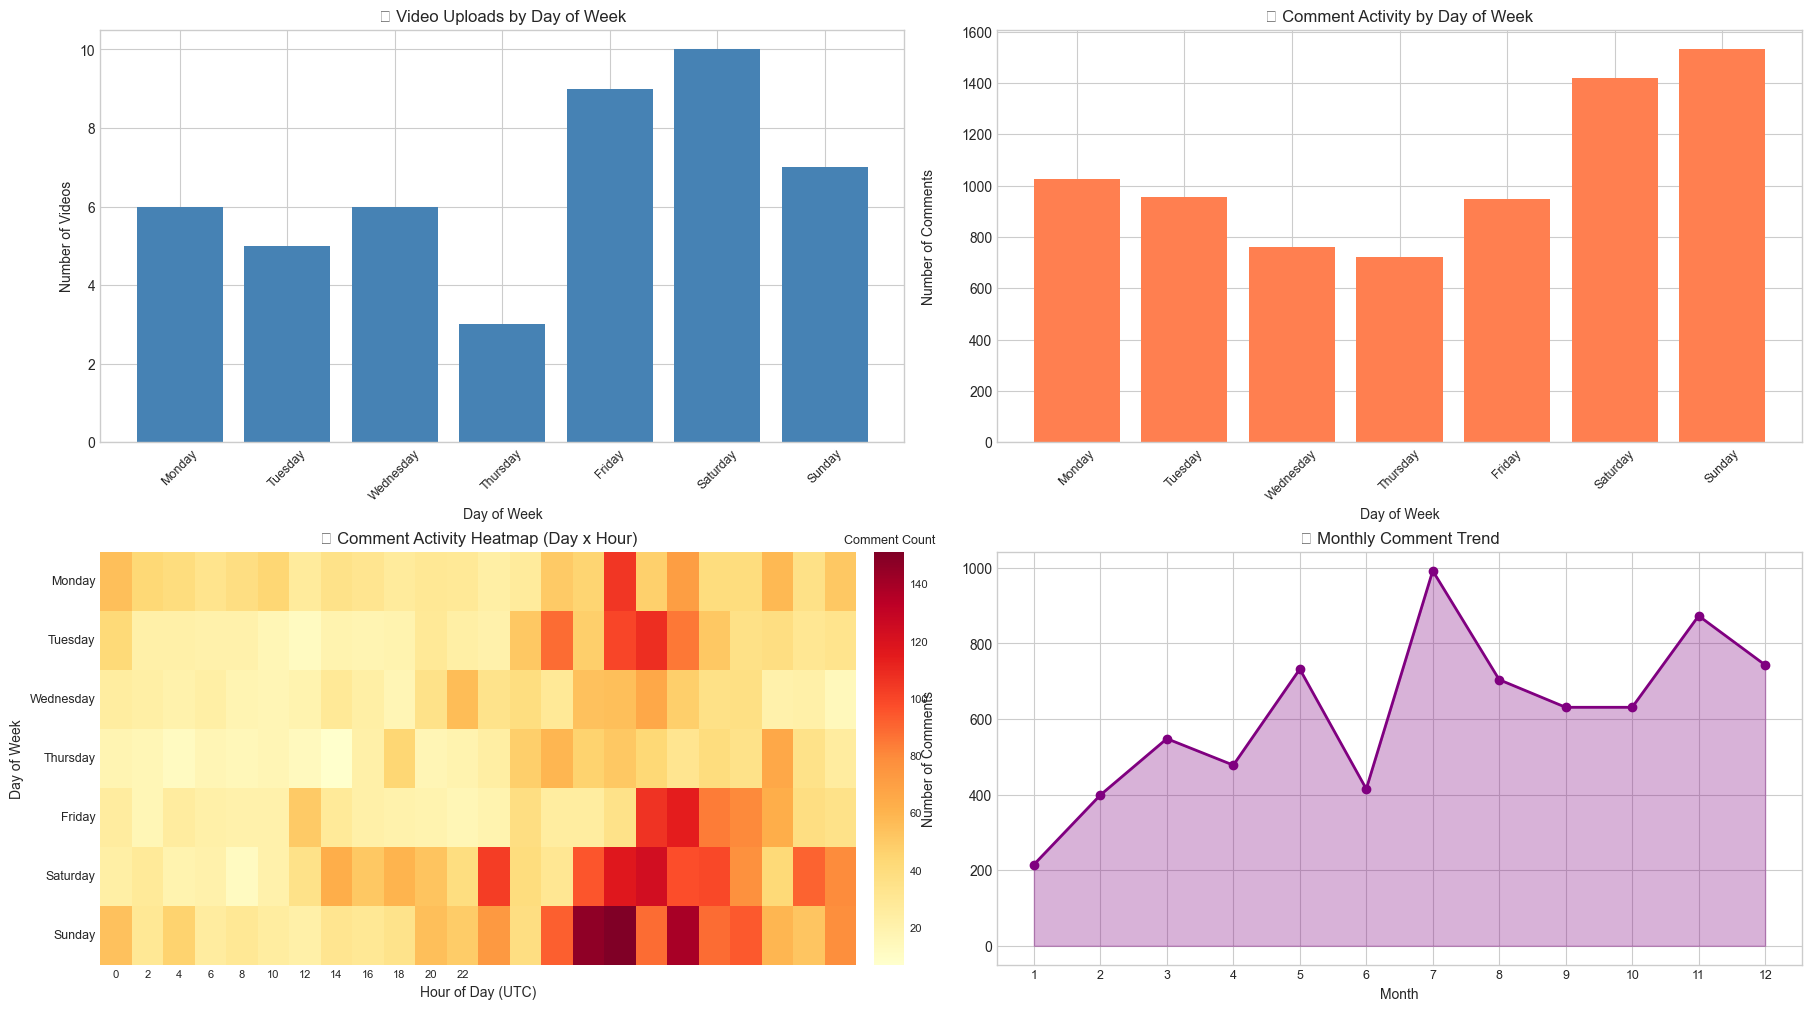

In [65]:
# Temporal Activity Analysis (fixed heatmap positioning + non-overlapping labels)
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Use a GridSpec layout + explicit colorbar axis so the heatmap doesn't get squished/moved
fig = plt.figure(figsize=(18, 10), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])

# Video uploads by day of week
video_temporal = analytics.temporal_activity_videos()
if not video_temporal.empty:
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    video_temporal = video_temporal.copy()
    video_temporal['day_name'] = pd.Categorical(video_temporal['day_name'], categories=day_order, ordered=True)
    video_temporal = video_temporal.sort_values('day_name')

    ax00.bar(video_temporal['day_name'], video_temporal['video_count'], color='steelblue')
    ax00.set_xlabel('Day of Week')
    ax00.set_ylabel('Number of Videos')
    ax00.set_title('📅 Video Uploads by Day of Week')
    ax00.tick_params(axis='x', rotation=45, labelsize=9)
else:
    ax00.axis('off')
    ax00.text(0.5, 0.5, 'No video temporal data', ha='center', va='center', transform=ax00.transAxes)

# Comment activity by day
comment_temporal = analytics.temporal_activity_comments()
if not comment_temporal.empty:
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    comment_temporal = comment_temporal.copy()
    comment_temporal['day_name'] = pd.Categorical(comment_temporal['day_name'], categories=day_order, ordered=True)
    comment_temporal = comment_temporal.sort_values('day_name')

    ax01.bar(comment_temporal['day_name'], comment_temporal['comment_count'], color='coral')
    ax01.set_xlabel('Day of Week')
    ax01.set_ylabel('Number of Comments', labelpad=18)
    ax01.set_title('💬 Comment Activity by Day of Week')
    ax01.tick_params(axis='x', rotation=45, labelsize=9)
else:
    ax01.axis('off')
    ax01.text(0.5, 0.5, 'No comment temporal data', ha='center', va='center', transform=ax01.transAxes)

# Heatmap of comment activity (day x hour)
heatmap_data = analytics.temporal_heatmap_data()
if not heatmap_data.empty:
    # Reserve a dedicated colorbar axis so seaborn doesn't distort the subplot grid
    divider = make_axes_locatable(ax10)
    cax = divider.append_axes('right', size='4%', pad=0.18)

    # Show fewer hour labels to avoid overlap (e.g., every 2 hours)
    hour_step = 2
    xticklabels = True
    if hasattr(heatmap_data, 'shape') and heatmap_data.shape[1] > 0:
        xticklabels = list(range(0, heatmap_data.shape[1], hour_step))

    sns.heatmap(
        heatmap_data,
        cmap='YlOrRd',
        ax=ax10,
        cbar=True,
        cbar_ax=cax,
        xticklabels=xticklabels,
        yticklabels=True,
    )
    ax10.set_xlabel('Hour of Day (UTC)')
    ax10.set_ylabel('Day of Week')
    ax10.set_title('🔥 Comment Activity Heatmap (Day x Hour)')

    # Move colorbar label to the top
    cax.set_ylabel('')
    cax.set_title('Comment Count', pad=6, fontsize=9)
    cax.tick_params(labelsize=8)

    # Final label polish: smaller fonts
    ax10.tick_params(axis='x', labelrotation=0, labelsize=8)
    ax10.tick_params(axis='y', labelrotation=0, labelsize=9)
else:
    ax10.axis('off')
    ax10.text(0.5, 0.5, 'No heatmap data', ha='center', va='center', transform=ax10.transAxes)

# Monthly trend
if 'month' in comments.columns:
    monthly = comments.groupby('month').size().sort_index()
    ax11.plot(monthly.index, monthly.values, marker='o', color='purple', linewidth=2)
    ax11.fill_between(monthly.index, monthly.values, alpha=0.3, color='purple')
    ax11.set_xlabel('Month')
    ax11.set_ylabel('Number of Comments', labelpad=18)
    ax11.set_title('📈 Monthly Comment Trend')
    ax11.set_xticks(range(1, 13))
    ax11.tick_params(axis='x', labelsize=9)
else:
    ax11.axis('off')
    ax11.text(0.5, 0.5, 'No month column in comments', ha='center', va='center', transform=ax11.transAxes)

plt.show()

---
# 📋 5. SUMMARY & EXPORT

## Generate Full Report

In [60]:
# Save all analytics to CSV files
# (Reload analytics module to pick up any code fixes without restarting the kernel)
import importlib
import src.analytics as analytics_module

importlib.reload(analytics_module)
from src.analytics import F1DescriptiveAnalytics

# Re-create analytics engine using the latest code
analytics = F1DescriptiveAnalytics(videos, comments)
analytics.save_report_to_csv()

print("\n✅ All analytics saved to processed data directory!")

Generating comprehensive analytics report...
Report generation complete!
Saved: C:\Users\ahmed\Downloads\dba-youtube-project\Descriptive\data\processed\driver_share_of_voice.csv
Saved: C:\Users\ahmed\Downloads\dba-youtube-project\Descriptive\data\processed\driver_sentiment_scores.csv
Saved: C:\Users\ahmed\Downloads\dba-youtube-project\Descriptive\data\processed\headline_impact.csv
Saved: C:\Users\ahmed\Downloads\dba-youtube-project\Descriptive\data\processed\rivalry_intensity.csv
Saved: C:\Users\ahmed\Downloads\dba-youtube-project\Descriptive\data\processed\top_comments.csv
Saved: C:\Users\ahmed\Downloads\dba-youtube-project\Descriptive\data\processed\controversial_videos.csv
Saved: C:\Users\ahmed\Downloads\dba-youtube-project\Descriptive\data\processed\top_engagement.csv
Saved: C:\Users\ahmed\Downloads\dba-youtube-project\Descriptive\data\processed\top_reach.csv
Saved: C:\Users\ahmed\Downloads\dba-youtube-project\Descriptive\data\processed\top_virality.csv
Saved: C:\Users\ahmed\Downlo

In [61]:
print("""
╔══════════════════════════════════════════════════════════════╗
║           F1 YouTube Descriptive Analytics Complete!          ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║  📊 METRICS COMPUTED:                                        ║
║                                                              ║
║  1. DRIVER ENGAGEMENT                                        ║
║     ✓ Driver Share of Voice (SoV)                           ║
║     ✓ Driver Sentiment Score                                ║
║     ✓ Headline Impact                                       ║
║     ✓ Rivalry Intensity                                     ║
║                                                              ║
║  2. AUDIENCE SENTIMENT                                       ║
║     ✓ Global Sentiment Distribution                         ║
║     ✓ Top Fan Favorite Comments                             ║
║     ✓ Controversy Index                                     ║
║     ✓ Polarity vs Performance Correlation                   ║
║                                                              ║
║  3. VIDEO PERFORMANCE                                        ║
║     ✓ Engagement Rate Rankings                              ║
║     ✓ Video Reach Rankings                                  ║
║     ✓ Virality Potential Rankings                           ║
║                                                              ║
║  4. CONTENT ANALYSIS                                         ║
║     ✓ Dominant Keyword Cloud                                ║
║     ✓ Team Mention Frequency                                ║
║     ✓ Temporal Activity Heatmap                             ║
║                                                              ║
╚══════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════╗
║           F1 YouTube Descriptive Analytics Complete!          ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║  📊 METRICS COMPUTED:                                        ║
║                                                              ║
║  1. DRIVER ENGAGEMENT                                        ║
║     ✓ Driver Share of Voice (SoV)                           ║
║     ✓ Driver Sentiment Score                                ║
║     ✓ Headline Impact                                       ║
║     ✓ Rivalry Intensity                                     ║
║                                                              ║
║  2. AUDIENCE SENTIMENT                                       ║
║     ✓ Global Sentiment Distribution                         ║
║     ✓ Top Fan Favorite Comments                             ║
║     ✓ Controversy Index     